# United States Airlines Analysis

## Problem Statement
According to air travel consumer reports, a large proportion of consumer complaints are about frequent flight delays. Out of all the complaints received from consumers about airline services, 32% were related to cancellations, delays, or other deviations from the airlines’ schedules. There are unavoidable delays that can be caused by air traffic, no passengers at the airport, weather conditions, mechanical issues, passengers coming from delayed connecting flights, security clearance, and aircraft preparation.

## Objective 
The objective of this project is to identify the factors that contribute to avoidable flight delays.
You are also required to build a model to predict if the flight will be delayed.

## Project Task: 
### Applied data science with Python	

1.	Import and aggregate data:
    * a.	Collect information related to flights, airports (e.g., type of airport and elevation), and runways (e.g., length_ft,           width_ft, surface, and number of runways). Gather all fields you believe might cause avoidable delays in one dataset.
    (Hint: In this case, you would have to determine the keys to join the tables. A data description will be useful.
    * b.	When it comes to on-time arrivals, different airlines perform differently based on the amount of experience they have.         The major airlines in this field include US Airways Express (founded in 1967) Continental Airlines (founded in 1934),           and Express Jet (founded in 19860. Pull such information specific to various airlines from the Wikipedia page link             given below.     
        https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States.
    (Hint: Here, you should use web scraping to learn how long an airline has been operating.)	
   * c.	You should then get all the information gathered so far in one place.
   * d.	The total passenger traffic may also contribute to flight delays. The term hub refers to busy commercial airports.             Large hubs are airports that account for at least 1 percent of the total passenger enplanements in the United States.           Airports that account for 0.25 percent to 1 percent of total passenger enplanements are considered medium hubs. Pull           passenger traffic data from the Wikipedia page given below using web scraping and collate it in a table.
        https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States

2.	You should then examine the missing values in each field, perform missing value treatment, and justify your actions.
 
3.	Perform data visualization and share your insights on the following points:
    * a.	According to the data provided, approximately 70% of Southwest Airlines flights are
        delayed. Visualize it to compare it with the data of other airlines.
    * b.	Flights were delayed on various weekdays. Which day of the week is the safest for travel?
    * c.	Which airlines should be recommended for short-, medium-, and long-distance travel?
    * d.	Do you notice any patterns in the departure times of long-duration flights?

4.	How many flights were delayed at large hubs compared to medium hubs? Use appropriate visualization to represent your           findings.
 
5.	Use hypothesis testing strategies to discover:
    * a.	If the airport's altitude has anything to do with flight delays for incoming and departing flights
    * b.	If the number of runways at an airport affects flight delays
    * c.	If the duration of a flight (length) affects flight delays
   (Hint: Test this from the perspective of both the source and destination airports)

6.	Find the correlation matrix between the flight delay predictors, create a heatmap to visualize this, and share your             findings
 
### Machine learning	

1.	Use OneHotEncoder and OrdinalEncoder to deal with categorical variables

2.	Perform the following model building steps:
    * a.	Apply logistic regression (use stochastic gradient descent optimizer) and decision tree models
    * b.	Use the stratified five-fold method to build and validate the models
    Note: Make sure you use standardization effectively, ensuring no data leakage and leverage pipelines to have a cleaner code
    * c.	Use RandomizedSearchCV for hyperparameter tuning, and use k-fold for cross- validation
    * d.	Keep a few data points (10%) for prediction purposes to evaluate how you would make the final prediction, and do not       use this data for testing or validation 
    Note: The final prediction will be based on the voting (majority class by 5 models created using the stratified 5-fold         method)
    * g. Compare the results of logistic regression and decision tree classifier

3.	Use the stratified five-fold method to build and validate the models using the XGB classifier, compare all methods, and         share your findings


In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from scipy.stats import ttest_1samp,ttest_ind,mannwhitneyu,levene,shapiro
from statsmodels.stats.power import ttest_power
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [4]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [5]:
airlines = pd.read_excel('Airlines.xlsx')

In [6]:
airports = pd.read_excel('airports.xlsx')

In [7]:
runways = pd.read_excel('runways.xlsx')

In [8]:
print(airlines.shape)
print(airports.shape)
print(runways.shape)

(518556, 9)
(73805, 18)
(43977, 20)


In [9]:
airlines.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [10]:
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [11]:
runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


## 1. Import and aggregate data:
### (a) Collect information related to flights, airports (e.g., type of airport and elevation), and runways (e.g., length_ft, width_ft, surface, and number of runways). Gather all fields you believe might cause avoidable delays in one dataset. 
* (Hint: In this case, you would have to determine the keys to join the tables. A data description will be useful.

In [12]:
combined = pd.merge(airports,runways,left_on = 'ident', right_on = 'airport_ident', how = 'left')
combined.head()

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,...,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,...,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,...,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,...,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN


In [13]:
runway_count = pd.DataFrame(combined.ident.value_counts())
runway_count.head()

,ident
KORD,11
KNHU,10
JRA,9
1LA9,8
SXS,8


In [14]:
runway_count.rename(columns = {'ident':'runway_count'}, inplace = True)
runway_count['ident'] = runway_count.index
runway_count.head()

,runway_count,ident
KORD,11,KORD
KNHU,10,KNHU
JRA,9,JRA
1LA9,8,1LA9
SXS,8,SXS


In [15]:
runway_count.to_excel('runway_count.xlsx')

In [15]:
air_run = pd.merge(airports, runway_count, how = 'left', left_on = 'ident', right_on = 'ident')[['iata_code', 'type', 'elevation_ft','runway_count']]
air_run.head()

,iata_code,type,elevation_ft,runway_count
0,NaN,heliport,11.0,1
1,NaN,small_airport,3435.0,1
2,NaN,small_airport,450.0,1
3,NaN,small_airport,820.0,1
4,NaN,closed,237.0,1


In [16]:
air_run['iata_code'].unique()

array([nan, 'UTK', 'OCA', ..., 'YNJ', 'YKH', 'ZYW'], dtype=object)

In [17]:
air_run['iata_code'].nunique()
air_run.to_csv('air_run.csv')

In [18]:
df = pd.merge(airlines, air_run, how = 'left', left_on = 'AirportFrom', right_on = 'iata_code')

In [19]:
df.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code,type,elevation_ft,runway_count
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0


In [20]:
df.rename(columns = {'iata_code':'iata_code_source_airport','type':'type_source_airport',
                     'elevation_ft':'elevation_ft_source_airport','runway_count':'runway_count_source_airport'}, inplace = True)

In [21]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0


In [22]:
df.shape

(518556, 13)

In [23]:
df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_count_source_airport'],
      dtype='object')

In [24]:
df = pd.merge(df, air_run, how = 'left', left_on = 'AirportTo', right_on = 'iata_code')

In [25]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,iata_code,type,elevation_ft,runway_count
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0,DFW,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0,DFW,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0,SEA,large_airport,433.0,4.0


In [26]:
df.rename(columns = {'iata_code':'iata_code_dest_airport','type':'type_dest_airport',
                     'elevation_ft':'elevation_ft_dest_airport','runway_count':'runway_count_dest_airport'}, inplace = True)

In [27]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,iata_code_dest_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,LAX,large_airport,125.0,4.0,DFW,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,SFO,large_airport,13.0,4.0,DFW,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,ANC,large_airport,152.0,3.0,SEA,large_airport,433.0,4.0


In [28]:
df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_count_source_airport', 'iata_code_dest_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport'],
      dtype='object')

In [29]:
df.drop(['iata_code_source_airport','iata_code_dest_airport'],axis=1,inplace=True)

In [30]:
df.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0


### 1.(b) When it comes to on-time arrivals, different airlines perform differently based on the amount of experience they have. The major airlines in this field include US Airways Express (founded in 1967) Continental Airlines (founded in 1934), and Express Jet (founded in 19860. Pull such information specific to various airlines from the Wikipedia page link given below. https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States.
* Hint: Here, you should use web scraping to learn how long an airline has been operating.


In [31]:
wikiurl = 'https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States'
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(wikiurl)
print(response.status_code)

200


In [32]:
soup = BeautifulSoup(response.text, 'html.parser')
airline = soup.find_all('table', {"class": "wikitable", "class": "sortable"})
print(airline[0])

<table class="wikitable sortable" style="border: 0; cellpadding: 2; cellspacing: 3;">
<tbody><tr style="vertical-align:middle;">
<th>Airline
</th>
<th>Image
</th>
<th><a class="mw-redirect" href="/wiki/IATA_airline_designator" title="IATA airline designator">IATA</a>
</th>
<th><a class="mw-redirect" href="/wiki/ICAO_airline_designator" title="ICAO airline designator">ICAO</a>
</th>
<th><a href="/wiki/Call_sign#Aviation" title="Call sign">Callsign</a>
</th>
<th>Primary hubs, <br/> <i>Secondary hubs</i>
</th>
<th>Founded
</th>
<th class="unsortable">Notes
</th></tr>
<tr>
<td><a href="/wiki/Alaska_Airlines" title="Alaska Airlines">Alaska Airlines</a>
</td>
<td><a class="image" href="/wiki/File:N615AS_Alaska_Airlines_2000_Boeing_737-790_C_N_30344_(28850996478).jpg"><img alt="N615AS Alaska Airlines 2000 Boeing 737-790 C N 30344 (28850996478).jpg" data-file-height="1079" data-file-width="1851" decoding="async" height="58" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f7/N615AS_Alaska

In [33]:
tables = pd.read_html(str(airline[0]))
print(tables[0])

                 Airline  Image IATA ICAO         Callsign  \
0        Alaska Airlines    NaN   AS  ASA           ALASKA   
1          Allegiant Air    NaN   G4  AAY        ALLEGIANT   
2      American Airlines    NaN   AA  AAL         AMERICAN   
3         Avelo Airlines    NaN   XP  VXP            AVELO   
4         Breeze Airways    NaN   MX  MXY             MOXY   
5        Delta Air Lines    NaN   DL  DAL            DELTA   
6       Eastern Airlines    NaN   2D  EAL          EASTERN   
7      Frontier Airlines    NaN   F9  FFT  FRONTIER FLIGHT   
8      Hawaiian Airlines    NaN   HA  HAL         HAWAIIAN   
9                JetBlue    NaN   B6  JBU          JETBLUE   
10    Southwest Airlines    NaN   WN  SWA        SOUTHWEST   
11       Spirit Airlines    NaN   NK  NKS     SPIRIT WINGS   
12  Sun Country Airlines    NaN   SY  SCX      SUN COUNTRY   
13       United Airlines    NaN   UA  UAL           UNITED   

                         Primary hubs, Secondary hubs  Founded  \
0  

In [34]:
air = []
for i in range(0,7):
    tables = pd.read_html(str(airline[i]))
    air.append(pd.DataFrame(tables[0]))

In [35]:
air[0].columns

Index(['Airline', 'Image', 'IATA', 'ICAO', 'Callsign',
       'Primary hubs, Secondary hubs', 'Founded', 'Notes'],
      dtype='object')

In [36]:
air[0].drop(['Image','Callsign','Primary hubs, Secondary hubs','Notes'],axis=1,inplace=True)

In [37]:
air[0].head()

,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932
1,Allegiant Air,G4,AAY,1997
2,American Airlines,AA,AAL,1926
3,Avelo Airlines,XP,VXP,1987
4,Breeze Airways,MX,MXY,2018


In [38]:
mainline_airlines = air[0]

In [39]:
mainline_airlines.isna().sum()

Airline    0
IATA       0
ICAO       0
Founded    0
dtype: int64

In [40]:
regional_airlines = air[1]
regional_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
regional_airlines.head()

,Airline,IATA,ICAO,Founded
0,Air Wisconsin,ZW,AWI,1965
1,Cape Air,9K,KAP,1988
2,CommutAir,C5,UCA,1989
3,Contour Airlines,LF,VTE,1982
4,Elite Airways,7Q,MNU,2006


In [41]:
commuter_airlines = air[2]
commuter_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
commuter_airlines.head()

,Airline,IATA,ICAO,Founded
0,Advanced Air,AN,WSN,2005
1,Air Sunshine,YI,RSI,1982
2,Bering Air,8E,BRG,1979
3,Boutique Air,4B,BTQ,2007
4,Everts Air,5V,VTS,1978


In [42]:
charter_airlines = air[3]
charter_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
charter_airlines.head()

,Airline,IATA,ICAO,Founded
0,Air Charter Bahamas,NaN,NaN,NaN
1,Air Flight Charters,NaN,FLL,1987.0
2,Airshare,NaN,XSR,2000.0
3,Berry Aviation,NaN,BYA,1983.0
4,Bighorn Airways,NaN,BHR,1947.0


In [43]:
cargo_airlines = air[4]
cargo_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
cargo_airlines.head()

,Airline,IATA,ICAO,Founded
0,21 Air,2I,CSB,2014.0
1,ABX Air,GB,ABX,1980.0
2,Air Cargo Carriers,2Q,SNC,1986.0
3,AirNet Express,NaN,USC,1974.0
4,Air Transport International,8C,ATN,1978.0


In [44]:
air_ambulances = air[5]
air_ambulances.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
air_ambulances.head()

,Airline,IATA,ICAO,Founded
0,AirMed International,NaN,NaN,1987.0
1,Air Methods,NaN,NaN,1980.0
2,Critical Air Medicine,NaN,NaN,1984.0
3,Lifestar,NaN,NaN,NaN
4,Life Lion,NaN,NaN,NaN


In [45]:
state_run_airlines = air[6]
state_run_airlines.drop(['Image','Callsign','Primary Hubs, Secondary Hubs','Notes'],axis=1,inplace=True)
state_run_airlines.head()

,Airline,IATA,ICAO,Founded
0,Comco,NaN,NaN,2002
1,Janet,NaN,WWW,1972
2,Justice Prisoner and Alien Transportation System,NaN,JUD,1980


In [46]:
all_airline = pd.concat([mainline_airlines,regional_airlines,commuter_airlines,charter_airlines,cargo_airlines,air_ambulances,
                         state_run_airlines],axis=0)
all_airline.shape

(140, 4)

In [47]:
all_airline.head(10)

,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932.0
1,Allegiant Air,G4,AAY,1997.0
2,American Airlines,AA,AAL,1926.0
3,Avelo Airlines,XP,VXP,1987.0
4,Breeze Airways,MX,MXY,2018.0
5,Delta Air Lines,DL,DAL,1924.0
6,Eastern Airlines,2D,EAL,2010.0
7,Frontier Airlines,F9,FFT,1994.0
8,Hawaiian Airlines,HA,HAL,1929.0
9,JetBlue,B6,JBU,1998.0


In [48]:
significant_airlines = pd.merge(df[['Airline']].drop_duplicates(),all_airline[['IATA', 'Founded']].drop_duplicates(), 
                                how = 'left', left_on = 'Airline', right_on = 'IATA')
significant_airlines

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


### 3.(d) The total passenger traffic may also contribute to flight delays. The term hub refers to busy commercial airports. Large hubs are airports that account for at least 1 percent of the total passenger enplanements in the United States. Airports that account for 0.25 percent to 1 percent of total passenger enplanements are considered medium hubs. Pull passenger traffic data from the Wikipedia page given below using web scraping and collate it in a table. https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States


In [49]:
wikiurl = 'https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States'
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(wikiurl)
print(response.status_code)

200


In [50]:
soup = BeautifulSoup(response.text, 'html.parser')
hub = soup.find_all('table', {"class": "wikitable", "class": "sortable"})
print(hub[0])

<table class="wikitable sortable">
<tbody><tr>
<th>Rank<br/>(2021)</th>
<th>Airports (large hubs)</th>
<th>IATA<br/>Code</th>
<th>Major cities served</th>
<th>State
</th>
<th>2021<sup class="reference" id="cite_ref-:0_3-0"><a href="#cite_note-:0-3">[3]</a></sup>
</th>
<th>2020<sup class="reference" id="cite_ref-CY20_4-0"><a href="#cite_note-CY20-4">[4]</a></sup></th>
<th>2019<sup class="reference" id="cite_ref-CY19_5-0"><a href="#cite_note-CY19-5">[5]</a></sup></th>
<th>2018<sup class="reference" id="cite_ref-CY18_6-0"><a href="#cite_note-CY18-6">[6]</a></sup></th>
<th>2017<sup class="reference" id="cite_ref-CY17_7-0"><a href="#cite_note-CY17-7">[7]</a></sup></th>
<th>2016<sup class="reference" id="cite_ref-CY16_8-0"><a href="#cite_note-CY16-8">[8]</a></sup></th>
<th>2015<sup class="reference" id="cite_ref-CY15_9-0"><a href="#cite_note-CY15-9">[9]</a></sup></th>
<th>2014<sup class="reference" id="cite_ref-CY14_10-0"><a href="#cite_note-CY14-10">[10]</a></sup></th>
<th>2013<sup class="r

In [51]:
tables = pd.read_html(str(hub[0]))
print(tables[0])

    Rank(2021)                             Airports (large hubs) IATACode  \
0            1  Hartsfield–Jackson Atlanta International Airport      ATL   
1            2           Dallas/Fort Worth International Airport      DFW   
2            3                      Denver International Airport      DEN   
3            4                      O'Hare International Airport      ORD   
4            5                 Los Angeles International Airport      LAX   
5            6           Charlotte Douglas International Airport      CLT   
6            7                     Orlando International Airport      MCO   
7            8                  Harry Reid International Airport      LAS   
8            9          Phoenix Sky Harbor International Airport      PHX   
9           10                       Miami International Airport      MIA   
10          11              Seattle–Tacoma International Airport      SEA   
11          12              George Bush Intercontinental Airport      IAH   

In [52]:
air_hub = []
for i in range(0,2):
    tables = pd.read_html(str(hub[i]))
    air_hub.append(pd.DataFrame(tables[0]))

In [53]:
large_hubs = air_hub[0]
large_hubs.head()

,Rank(2021),Airports (large hubs),IATACode,Major cities served,State,2021[3],2020[4],2019[5],2018[6],2017[7],2016[8],2015[9],2014[10],2013[11],2012[12]
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,45798928
1,2,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,28022904
2,3,Denver International Airport,DEN,Denver,CO,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,25799841
3,4,O'Hare International Airport,ORD,Chicago,IL,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835,32171795
4,5,Los Angeles International Airport,LAX,Los Angeles,CA,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892,31326268


In [54]:
large_hubs['Hub Size'] = "Large Hub"

In [55]:
large_hubs.rename(columns = {'Airports (large hubs)':'airport'}, inplace = True)

In [56]:
large_hubs.rename(columns = {'Major cities served':'city'}, inplace = True)

In [57]:
large_hubs

,Rank(2021),airport,IATACode,city,State,2021[3],2020[4],2019[5],2018[6],2017[7],2016[8],2015[9],2014[10],2013[11],2012[12],Hub Size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,45798928,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,28022904,Large Hub
2,3,Denver International Airport,DEN,Denver,CO,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,25799841,Large Hub
3,4,O'Hare International Airport,ORD,Chicago,IL,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835,32171795,Large Hub
4,5,Los Angeles International Airport,LAX,Los Angeles,CA,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892,31326268,Large Hub
5,6,Charlotte Douglas International Airport,CLT,Charlotte,NC,20900875,12952869,24199688,22281949,22011251,21511880,21913166,21537725,21346601,20033816,Large Hub
6,7,Orlando International Airport,MCO,Orlando,FL,19618838,10467728,24562271,23202480,21565448,20283541,18759938,17278608,16884524,17159427,Large Hub
7,8,Harry Reid International Airport,LAS,Las Vegas,NV,19160342,10584059,24728361,23795012,23364393,22833267,21857693,20620248,19946179,19959651,Large Hub
8,9,Phoenix Sky Harbor International Airport,PHX,Phoenix,AZ,18940287,10531436,22433552,21622580,21185458,20896265,21351504,20344867,19525109,19560870,Large Hub
9,10,Miami International Airport,MIA,Miami,FL,17500096,8786007,21421031,21021640,20709225,20875813,20986349,19471466,19420089,18987488,Large Hub


In [58]:
medium_hubs = air_hub[1]
medium_hubs.head()

,Rank(2021),Airports (medium hubs),IATACode,City served,State,2021[3],2020[4],2019[5],2018[6],2017[7],2016[8],2015[9],2014[10],2013[11],2012[12]
0,31,Dallas Love Field,DAL,Dallas,TX,6487563,3669930,8408457,8134848,7876769,7554596,7040921,4522341,4023779,3902628
1,32,Daniel K. Inouye International Airport,HNL,Honolulu,HI,5830928,3126391,9988678,9578505,9743989,9656340,9656340,9463000,9466995,9225848
2,33,Portland International Airport,PDX,Portland,OR,5759879,3455877,9797408,9940866,9435473,9071154,8340234,7878760,7452603,7142620
3,34,William P. Hobby Airport,HOU,Houston,TX,5560780,3127178,7069614,6937061,6741870,6285181,5937944,5800726,5377050,5043737
4,35,Southwest Florida International Airport,RSW,Fort Myers,FL,5080805,2947139,5144467,4719568,4461304,4350650,4231134,4025959,3788870,3634152


In [59]:
medium_hubs['Hub Size'] = "Medium Hub"

In [60]:
medium_hubs.rename(columns = {'Airports (medium hubs)':'airport'}, inplace = True)
medium_hubs.rename(columns = {'City served':'city'}, inplace = True)
medium_hubs.head()

,Rank(2021),airport,IATACode,city,State,2021[3],2020[4],2019[5],2018[6],2017[7],2016[8],2015[9],2014[10],2013[11],2012[12],Hub Size
0,31,Dallas Love Field,DAL,Dallas,TX,6487563,3669930,8408457,8134848,7876769,7554596,7040921,4522341,4023779,3902628,Medium Hub
1,32,Daniel K. Inouye International Airport,HNL,Honolulu,HI,5830928,3126391,9988678,9578505,9743989,9656340,9656340,9463000,9466995,9225848,Medium Hub
2,33,Portland International Airport,PDX,Portland,OR,5759879,3455877,9797408,9940866,9435473,9071154,8340234,7878760,7452603,7142620,Medium Hub
3,34,William P. Hobby Airport,HOU,Houston,TX,5560780,3127178,7069614,6937061,6741870,6285181,5937944,5800726,5377050,5043737,Medium Hub
4,35,Southwest Florida International Airport,RSW,Fort Myers,FL,5080805,2947139,5144467,4719568,4461304,4350650,4231134,4025959,3788870,3634152,Medium Hub


In [61]:
final_hub_data = pd.concat([large_hubs, medium_hubs])
final_hub_data

,Rank(2021),airport,IATACode,city,State,2021[3],2020[4],2019[5],2018[6],2017[7],2016[8],2015[9],2014[10],2013[11],2012[12],Hub Size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,45798928,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,28022904,Large Hub
2,3,Denver International Airport,DEN,Denver,CO,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,25799841,Large Hub
3,4,O'Hare International Airport,ORD,Chicago,IL,26350976,14606034,40871223,39873927,38593028,37589899,36305668,33843426,32317835,32171795,Large Hub
4,5,Los Angeles International Airport,LAX,Los Angeles,CA,23663410,14055777,42939104,42624050,41232432,39636042,36351272,34314197,32425892,31326268,Large Hub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,61,Boise Airport,BOI,Boise,ID,1809000,991241,2057750,1943181,1777642,1633507,1487777,1378352,1313741,1307505,Medium Hub
31,62,Memphis International Airport,MEM,Memphis,TN,1793073,1015981,2318442,2213083,2102739,2016089,1873716,1800268,2301003,3359668,Medium Hub
32,63,Reno–Tahoe International Airport,RNO,Reno,NV,1781785,976937,2162250,2048916,1953028,1771864,1669876,1611572,1671926,1685333,Medium Hub
33,64,Albuquerque International Sunport,ABQ,Albuquerque,NM,1688646,868922,2641450,2647269,2412328,2341719,2323883,2354184,2477783,2630574,Medium Hub


In [62]:
column_temp = final_hub_data.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ','_').values
column_temp[list(map( lambda x : x.isnumeric(), column_temp))]  = 'data_' + column_temp[list(map( lambda x : x.isnumeric(), column_temp))] 
final_hub_data.columns = column_temp
final_hub_data.columns

Index(['rank', 'airport', 'iatacode', 'city', 'state', 'data_2021',
       'data_2020', 'data_2019', 'data_2018', 'data_2017', 'data_2016',
       'data_2015', 'data_2014', 'data_2013', 'data_2012', 'hub_size'],
      dtype='object')

In [63]:
final_hub_data.head(3)

,rank,airport,iatacode,city,state,data_2021,data_2020,data_2019,data_2018,data_2017,data_2016,data_2015,data_2014,data_2013,data_2012,hub_size
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,36676010,20559866,53505795,51865797,50251964,50501858,49340732,46604273,45308407,45798928,Large Hub
1,2,Dallas/Fort Worth International Airport,DFW,Dallas & Fort Worth,TX,30005266,18593421,35778573,32821799,31816933,31283579,31589839,30804567,29038128,28022904,Large Hub
2,3,Denver International Airport,DEN,Denver,CO,28645527,16243216,33592945,31362941,29809097,28267394,26280043,26000591,25496885,25799841,Large Hub


In [64]:
final_hub_data.isna().sum()

rank         0
airport      0
iatacode     0
city         0
state        0
data_2021    0
data_2020    0
data_2019    0
data_2018    0
data_2017    0
data_2016    0
data_2015    0
data_2014    0
data_2013    0
data_2012    0
hub_size     0
dtype: int64

In [65]:
final_hub_data.to_csv('hub_data.csv')

In [65]:
master_df = pd.merge(df, final_hub_data[['iatacode', 'data_2021']],how = 'left' , left_on = 'AirportFrom', right_on = 'iatacode')

In [66]:
master_df.rename(columns = {'iatacode': 'iatacode_source' ,'data_2021': 'data_2021_source_airport'}, inplace = True)

In [67]:
master_df = pd.merge(master_df, final_hub_data[['iatacode', 'data_2021']],how = 'left' , left_on = 'AirportTo', right_on = 'iatacode')

In [68]:
master_df.rename(columns = {'iatacode': 'iatacode_dest' ,'data_2021': 'data_2021_dest_airport'}, inplace = True)

In [69]:
master_df.head(3)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iatacode_source,data_2021_source_airport,iatacode_dest,data_2021_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,11725347.0,IAH,16242821.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,PHX,18940287.0,CLT,20900875.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,LAX,23663410.0,DFW,30005266.0


In [70]:
master_df.drop(['iatacode_source','iatacode_dest'],axis=1,inplace=True)

In [71]:
significant_airlines

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [72]:
master_df = pd.merge(master_df, significant_airlines[['Airline', 'Founded']], on = 'Airline')

In [73]:
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,NaN
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,NaN
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,NaN
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,NaN
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,NaN


## 2. You should then examine the missing values in each field, perform missing value treatment, and justify your actions.

In [74]:
master_df.isna().sum()

id                                 0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Length                             0
Delay                              0
type_source_airport               31
elevation_ft_source_airport       31
runway_count_source_airport       31
type_dest_airport                 31
elevation_ft_dest_airport         31
runway_count_dest_airport         31
data_2021_source_airport       83582
data_2021_dest_airport         83531
Founded                        83601
dtype: int64

In [75]:
master_df[master_df.type_source_airport.isna()].AirportFrom.unique()

array(['CYS'], dtype=object)

In [76]:
master_df[master_df.type_dest_airport.isna()].AirportTo.unique()

array(['CYS'], dtype=object)

Here we can clearly see that information regarding 'CYS' is missing. Let's import 'Data Dictionary' provided in datasets. Check if it has any information on this.

In [77]:
data_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name = 'airlines',header = 29, usecols = [0,1])
data_dict.head()

,Aiport ID,Description
0,ABE,RAF Calveley
1,ABE,Bisho Airport
2,ABE,Beica Airport
3,ABE,Lehigh Valley International Airport
4,ABE,Bethel Airport


In [78]:
name = data_dict[data_dict['Aiport ID'] == 'CYS'].Description.values[0]
name.lower()

'cheyenne regional jerry olson field'

In [79]:
air_miss = airports.loc[name.lower() == airports.name.str.lower(), ['ident', 'name', 'iata_code', 'type', 'elevation_ft']]

In [80]:
air_miss

,ident,name,iata_code,type,elevation_ft
34675,KCYS,Cheyenne Regional Jerry Olson Field,NaN,medium_airport,6159.0


In [81]:
air_miss_comb = pd.merge(air_miss, runways[['airport_ident', 'id']], how = 'left', left_on = 'ident', right_on = 'airport_ident')
runway_count_miss = air_miss_comb.groupby('ident')[['id']].count().sort_values(by = 'id', ascending = False).reset_index()
runway_count_miss

,ident,id
0,KCYS,2


In [82]:
air_miss_data = pd.merge(air_miss,runway_count_miss ).rename(columns = {'id' : 'runway_count'})[['iata_code', 'type', 'elevation_ft', 'runway_count']]

In [83]:
air_miss_data

,iata_code,type,elevation_ft,runway_count
0,NaN,medium_airport,6159.0,2


In [84]:
master_df.loc[master_df.AirportFrom == 'CYS', 'type_source_airport'] = air_miss_data.type.values[0]
master_df.loc[master_df.AirportFrom == 'CYS', 'elevation_ft_source_airport'] = air_miss_data.elevation_ft.values[0]
master_df.loc[master_df.AirportFrom == 'CYS', 'runway_count_source_airport'] = air_miss_data.runway_count.values[0]

In [85]:
master_df.loc[master_df.AirportTo == 'CYS', 'type_dest_airport'] = air_miss_data.type.values[0]
master_df.loc[master_df.AirportTo == 'CYS', 'elevation_ft_dest_airport'] = air_miss_data.elevation_ft.values[0]
master_df.loc[master_df.AirportTo == 'CYS', 'runway_count_dest_airport'] = air_miss_data.runway_count.values[0]

In [86]:
master_df.isna().sum().sort_values(ascending = False)

Founded                        83601
data_2021_source_airport       83582
data_2021_dest_airport         83531
Airline                            0
runway_count_dest_airport          0
elevation_ft_dest_airport          0
type_dest_airport                  0
runway_count_source_airport        0
elevation_ft_source_airport        0
id                                 0
Delay                              0
Length                             0
Time                               0
DayOfWeek                          0
AirportTo                          0
AirportFrom                        0
Flight                             0
type_source_airport                0
dtype: int64

In [87]:
miss_founded = master_df[master_df.Founded.isna()].Airline.unique()
miss_founded

array(['CO', 'US', 'EV'], dtype=object)

In [88]:
airline_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name = 'airlines',header = 10, usecols = [0,1])
airline_dict.head()

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy


In [89]:
print(airline_dict[airline_dict['Airlines ID'].isin( ['EV', 'CO', 'US'])])

  Airlines ID                        Description
5          US  PSA (initially US Airway Express)
7          EV                         ExpressJet
9          CO     United Airlines (initially CO)


### use google for these years
* US - 1967
* CO - 1934
* EV - 1986

In [90]:
miss_val = {'US' : 1967, 'CO' : 1934, 'EV' : 1986}
for aline in miss_founded:
    master_df.loc[(master_df.Founded.isna()) & 
                      (master_df.Airline == aline), 'Founded'] = miss_val[aline] 

In [91]:
master_df.isna().sum().sort_values(ascending = False)

data_2021_source_airport       83582
data_2021_dest_airport         83531
id                                 0
Airline                            0
runway_count_dest_airport          0
elevation_ft_dest_airport          0
type_dest_airport                  0
runway_count_source_airport        0
elevation_ft_source_airport        0
type_source_airport                0
Delay                              0
Length                             0
Time                               0
DayOfWeek                          0
AirportTo                          0
AirportFrom                        0
Flight                             0
Founded                            0
dtype: int64

In [92]:
(master_df.isna().sum().sort_values(ascending = False)/master_df.shape[0])*100

data_2021_source_airport       16.118221
data_2021_dest_airport         16.108386
id                              0.000000
Airline                         0.000000
runway_count_dest_airport       0.000000
elevation_ft_dest_airport       0.000000
type_dest_airport               0.000000
runway_count_source_airport     0.000000
elevation_ft_source_airport     0.000000
type_source_airport             0.000000
Delay                           0.000000
Length                          0.000000
Time                            0.000000
DayOfWeek                       0.000000
AirportTo                       0.000000
AirportFrom                     0.000000
Flight                          0.000000
Founded                         0.000000
dtype: float64

In [93]:
master_df.groupby('type_source_airport')[['data_2021_source_airport']].median()

,data_2021_source_airport
type_source_airport,
large_airport,14514049.0
medium_airport,2273259.0
small_airport,NaN


In [94]:
med_val = master_df.groupby('type_source_airport')[['data_2021_source_airport']].median()
med_val

,data_2021_source_airport
type_source_airport,
large_airport,14514049.0
medium_airport,2273259.0
small_airport,NaN


In [95]:
for typ in master_df.type_source_airport.unique():
      master_df.loc[(master_df.type_source_airport == typ)& (master_df.data_2021_source_airport.isna()),
                      'data_2021_source_airport'] = med_val.loc[typ].values[0]

In [96]:
med_val_dest = master_df.groupby('type_dest_airport')[['data_2021_dest_airport']].median()
med_val_dest

,data_2021_dest_airport
type_dest_airport,
large_airport,14514049.0
medium_airport,2273259.0
small_airport,NaN


In [97]:
for typ in master_df.type_source_airport.unique():
      master_df.loc[(master_df.type_dest_airport == typ)& (master_df.data_2021_dest_airport.isna()),
                      'data_2021_dest_airport'] = med_val.loc[typ].values[0]

In [98]:
master_df.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0


In [99]:
(master_df.isna().sum().sort_values(ascending = False)/master_df.shape[0])*100

data_2021_source_airport       0.226205
data_2021_dest_airport         0.224855
id                             0.000000
Airline                        0.000000
runway_count_dest_airport      0.000000
elevation_ft_dest_airport      0.000000
type_dest_airport              0.000000
runway_count_source_airport    0.000000
elevation_ft_source_airport    0.000000
type_source_airport            0.000000
Delay                          0.000000
Length                         0.000000
Time                           0.000000
DayOfWeek                      0.000000
AirportTo                      0.000000
AirportFrom                    0.000000
Flight                         0.000000
Founded                        0.000000
dtype: float64

Now only 0.22 % missing values remains and these can be dropped from our dataset.

In [100]:
master_df = master_df.dropna()

In [101]:
(master_df.isna().sum().sort_values(ascending = False)/master_df.shape[0])*100

id                             0.0
Airline                        0.0
data_2021_dest_airport         0.0
data_2021_source_airport       0.0
runway_count_dest_airport      0.0
elevation_ft_dest_airport      0.0
type_dest_airport              0.0
runway_count_source_airport    0.0
elevation_ft_source_airport    0.0
type_source_airport            0.0
Delay                          0.0
Length                         0.0
Time                           0.0
DayOfWeek                      0.0
AirportTo                      0.0
AirportFrom                    0.0
Flight                         0.0
Founded                        0.0
dtype: float64

All of the missing values have been dropped.

## 3. Perform data visualization and share your insights on the following points:
### (a)	According to the data provided, approximately 70% of Southwest Airlines flights are delayed. Visualize it to compare it with the data of other airlines.


In [102]:
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0


In [103]:
airline_dict.head()

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy


In [104]:
master_df = pd.merge(master_df,airline_dict,left_on="Airline",right_on="Airlines ID",how='left')
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO)
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO)
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO)
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0,CO,United Airlines (initially CO)
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0,CO,United Airlines (initially CO)


In [105]:
id_airline = airline_dict.loc[airline_dict['Description'].str.strip().str.lower() == 'southwest', 'Airlines ID'].values[0]
id_airline

'WN'

In [106]:
def percent_Delay(x):
    return round(x.sum()/x.size * 100,2)

In [107]:
master_df.groupby('Airline')['Delay'].agg(percent_Delay)

Airline
9E    39.78
AA    38.84
AS    33.93
B6    46.70
CO    56.58
DL    45.05
EV    40.20
F9    44.92
HA    32.02
MQ    34.80
OH    27.83
OO    45.44
UA    32.39
US    33.60
WN    69.78
XE    37.90
YV    24.37
Name: Delay, dtype: float64

In [108]:
delay_perc = master_df.groupby('Airline')['Delay'].agg(percent_Delay)
delay_perc = delay_perc.reset_index()

In [109]:
delay_perc

,Airline,Delay
0,9E,39.78
1,AA,38.84
2,AS,33.93
3,B6,46.70
4,CO,56.58
5,DL,45.05
6,EV,40.20
7,F9,44.92
8,HA,32.02
9,MQ,34.80


In [110]:
delay_data = pd.merge(delay_perc,airline_dict,left_on="Airline",right_on="Airlines ID", how='left')[['Airline','Delay','Description']]

In [111]:
delay_data

,Airline,Delay,Description
0,9E,39.78,Endeavor
1,AA,38.84,American Airlines
2,AS,33.93,Alaska
3,B6,46.70,Jetblue
4,CO,56.58,United Airlines (initially CO)
5,DL,45.05,Delta
6,EV,40.20,ExpressJet
7,F9,44.92,Frontier
8,HA,32.02,Hawaiian
9,MQ,34.80,Envoy


<AxesSubplot:xlabel='Description'>

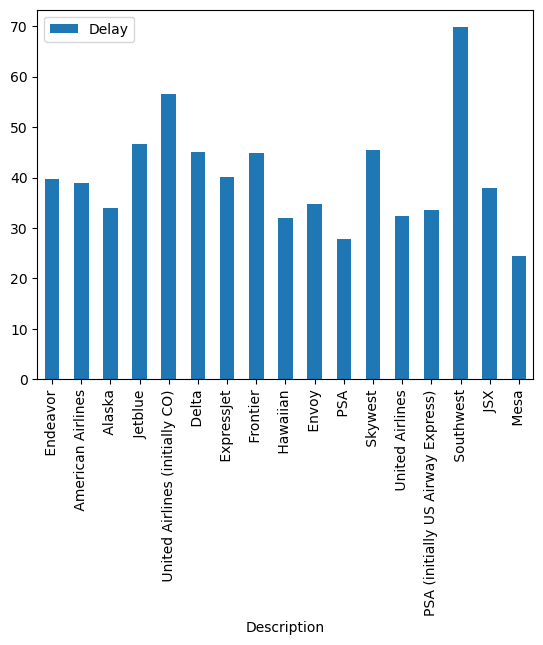

In [112]:
delay_data.plot(x='Description',y='Delay',kind='bar')

findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


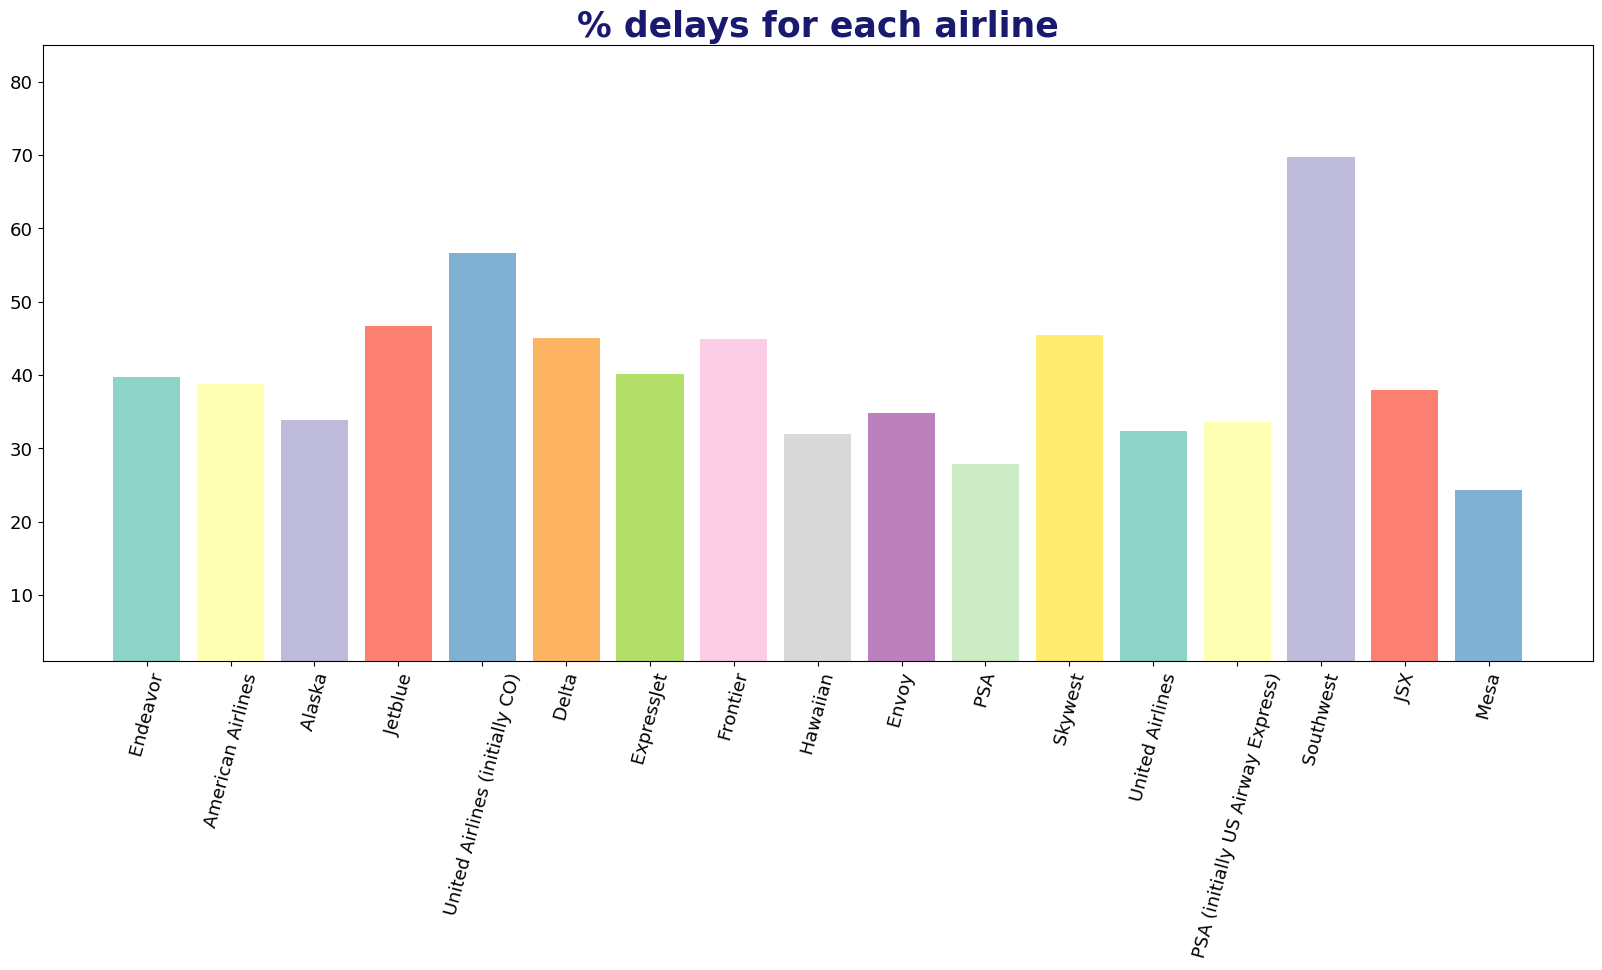

In [113]:
plt.figure(figsize = (20,8))
plt.bar(delay_data.Description, height =  delay_data.Delay, color = plt.get_cmap('Set3').colors)
plt.ylim(1,85)
plt.xticks(size = 13, rotation = 75)
plt.yticks(size = 13)
plt.title('% delays for each airline', size = 25, color = 'midnightblue', weight = 'heavy', family = 'times')
plt.show()

### b. Flights were delayed on various weekdays. Which day of the week is the safest for travel?

In [114]:
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO)
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO)
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO)
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0,CO,United Airlines (initially CO)
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0,CO,United Airlines (initially CO)


In [115]:
master_df['DayOfWeek'].value_counts()

4    87583
3    86101
5    81413
1    69693
2    68422
7    66908
6    56097
Name: DayOfWeek, dtype: int64

In [116]:
master_df['DayOfWeek'].value_counts()/len(master_df)*100

4    16.966315
3    16.679226
5    15.771081
1    13.500718
2    13.254503
7    12.961216
6    10.866942
Name: DayOfWeek, dtype: float64

In [117]:
delay_perc_weekday = master_df.groupby('DayOfWeek')['Delay'].agg(percent_Delay)
delay_perc_weekday

DayOfWeek
1    47.28
2    45.25
3    47.63
4    45.84
5    42.58
6    40.57
7    45.77
Name: Delay, dtype: float64

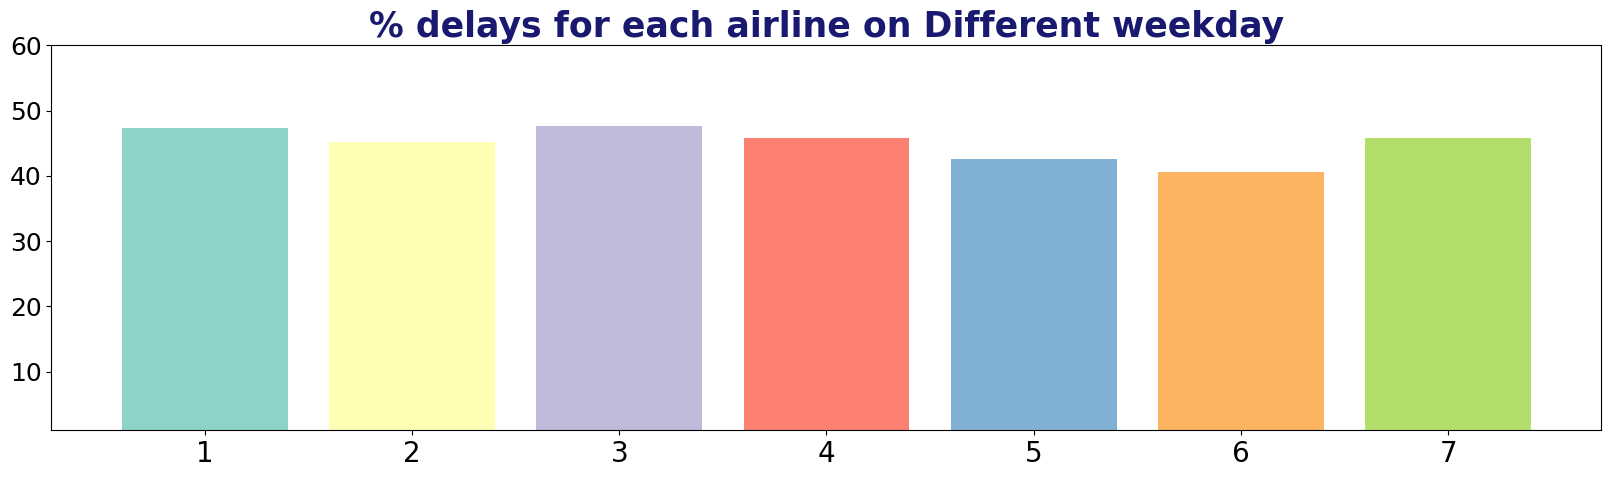

In [118]:
plt.figure(figsize = (20,5))
plt.bar(delay_perc_weekday.index, height =  delay_perc_weekday.values, color = plt.get_cmap('Set3').colors)
plt.ylim(1,60)
plt.xticks(size = 20)
plt.yticks(size = 18)
plt.title('% delays for each airline on Different weekday', size = 25, color = 'midnightblue', weight = 'heavy', family = 'times')
plt.show()

### (c)	Which airlines should be recommended for short-, medium-, and long-distance travel?

In [119]:
duration_data = master_df[['Airline', 'Length', 'Delay']].copy()

In [120]:
duration_data['duration'] = pd.cut(duration_data.Length, 3, labels = ['short', 'medium', 'long'])
duration_data_grp = duration_data.groupby(['Airline','duration'])['Delay'].agg(percent_Delay).reset_index().pivot(index = 'Airline', 
                                       columns = 'duration').fillna(0)['Delay']
duration_data_grp.columns = duration_data_grp.columns.astype(str)
duration_data_grp.reset_index()

duration,Airline,short,medium,long
0,9E,39.78,0.00,0.00
1,AA,37.61,43.25,60.40
2,AS,32.58,38.17,0.00
3,B6,45.70,51.05,0.00
4,CO,52.82,64.95,66.87
5,DL,43.87,50.24,48.62
6,EV,40.20,50.00,0.00
7,F9,45.04,43.56,0.00
8,HA,30.16,40.48,0.00
9,MQ,34.81,27.42,0.00


In [121]:
airline_dict.Description = airline_dict.Description.str.strip()
duration_data_grp = pd.merge(duration_data_grp,airline_dict[['Airlines ID', 'Description']],
                             left_on = 'Airline', right_on = 'Airlines ID', how = 'left')
duration_data_grp

,short,medium,long,Airlines ID,Description
0,39.78,0.00,0.00,9E,Endeavor
1,37.61,43.25,60.40,AA,American Airlines
2,32.58,38.17,0.00,AS,Alaska
3,45.70,51.05,0.00,B6,Jetblue
4,52.82,64.95,66.87,CO,United Airlines (initially CO)
5,43.87,50.24,48.62,DL,Delta
6,40.20,50.00,0.00,EV,ExpressJet
7,45.04,43.56,0.00,F9,Frontier
8,30.16,40.48,0.00,HA,Hawaiian
9,34.81,27.42,0.00,MQ,Envoy


In [122]:
long = duration_data_grp[duration_data_grp.long == duration_data_grp.long.min()].Description.values.tolist()
print('Airlines with no delays for long flights :\n',', '.join(long))
medium = duration_data_grp[duration_data_grp.medium == duration_data_grp.medium.min()].Description.values.tolist()
print('\nAirlines with no delays for medium flights :\n', ', '.join(medium))
short = duration_data_grp[duration_data_grp.short == duration_data_grp.short.min()].Description.values.tolist()
print('\nAirlines with no delays for short flights :\n',  ', '.join(short)     )

Airlines with no delays for long flights :
 Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa

Airlines with no delays for medium flights :
 Endeavor

Airlines with no delays for short flights :
 Mesa


### (d) Do you notice any patterns in the departure times of long-duration flights?

In [123]:
master_df['duration'] = pd.cut(master_df.Length, 3, labels = ['short', 'medium', 'long'])
master_df.head(3)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,...,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO),short


In [124]:
pd.crosstab(master_df.Time, master_df.duration)['long']

Time
10      0
15      0
20      0
21      0
25      0
       ..
1428    0
1430    0
1431    0
1435    0
1439    0
Name: long, Length: 1131, dtype: int64

In [125]:
y = pd.crosstab(master_df.Time, master_df.duration)['long'].index
x = pd.crosstab(master_df.Time, master_df.duration)['long'].values

In [126]:
filter_data = master_df.loc[master_df.duration == 'long', ['Time', 'duration']]

In [127]:
filter_data.Time.describe()

count     559.000000
mean      840.635063
std       221.020092
min       540.000000
25%       670.000000
50%       717.000000
75%      1045.000000
max      1310.000000
Name: Time, dtype: float64

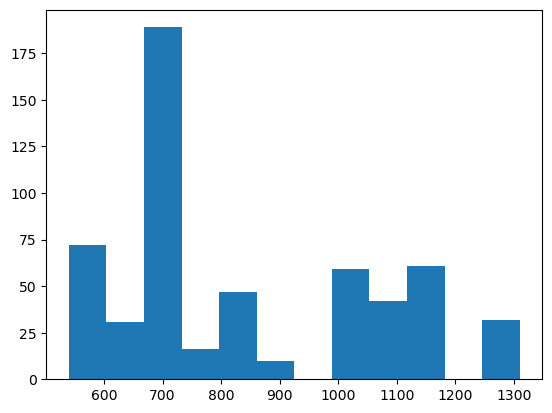

In [128]:
plt.hist(filter_data.Time, bins = 12)
plt.show()

In [129]:
# majority of long distant flights depart in the morning between 5 and 9.

## 4. How many flights were delayed at large hubs compared to medium hubs? Use appropriate visualization to represent your findings.

In [130]:
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,...,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO),short
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,...,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,...,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0,CO,United Airlines (initially CO),short


<AxesSubplot:xlabel='type_source_airport'>

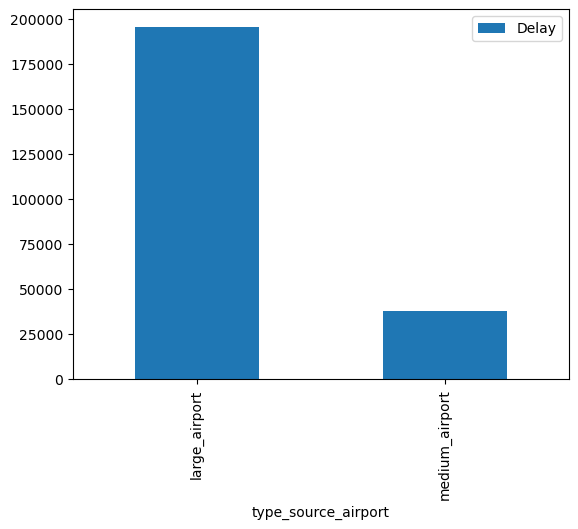

In [131]:
master_df.groupby('type_source_airport')[['Delay']].agg('sum').plot.bar()

<AxesSubplot:xlabel='type_dest_airport'>

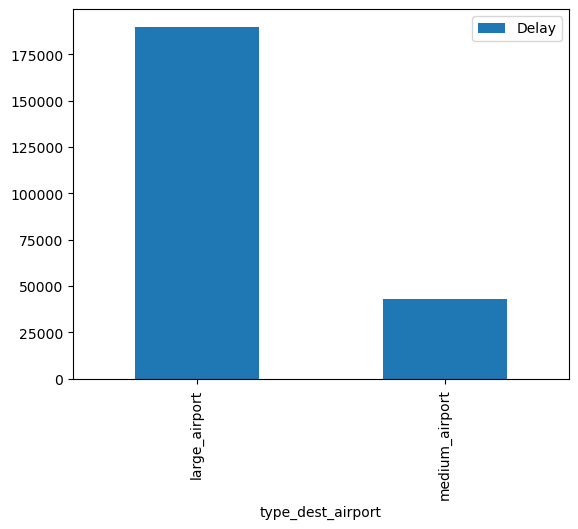

In [132]:
master_df.groupby('type_dest_airport')[['Delay']].agg('sum').plot.bar()

## 5. Use hypothesis testing strategies to discover:
### (a)	If the airport's altitude has anything to do with flight delays for incoming and departing flights

#### For outgoing flights

In [133]:
master_df.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'data_2021_source_airport',
       'data_2021_dest_airport', 'Founded', 'Airlines ID', 'Description',
       'duration'],
      dtype='object')

In [134]:
Ho = "Avg elevation for Delayed flights and not Delayed flights not significantly different"
Ha = "Avg elevation for Delayed flights and not Delayed flights are different"

In [135]:
x = np.array(master_df[master_df['Delay']==1].elevation_ft_source_airport)
x.shape

(233117,)

In [136]:
x

array([  13.,  125.,  152., ..., 2181.,   13.,  125.])

In [137]:
y=np.array(master_df[master_df['Delay']==0].elevation_ft_source_airport)
y

array([2181.,  944.,  107., ..., 1026.,   17.,   96.])

In [138]:
len(y)

283100

In [139]:
t,p_value = ttest_ind(x,y,axis=0)

In [140]:
p_value

1.909387572702128e-19

In [141]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Avg elevation for Delayed flights and not Delayed flights are different as the p_value(1.909387572702128e-19)<0.05


#### For incoming flights

In [143]:
Ho = "Avg elevation for Delayed flights and not Delayed flights not significantly different"
Ha = "Avg elevation for Delayed flights and not Delayed flights are different"

In [144]:
x = np.array(master_df[master_df['Delay']==1].elevation_ft_dest_airport)
x.shape

(233117,)

In [145]:
y=np.array(master_df[master_df['Delay']==0].elevation_ft_dest_airport)
y

array([  97.,   97.,   97., ...,  620., 1135.,    9.])

In [146]:
t,p_value = ttest_ind(x,y,axis=0)

In [147]:
p_value

2.7948729392515513e-21

In [148]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Avg elevation for Delayed flights and not Delayed flights are different as the p_value(2.7948729392515513e-21)<0.05


### (b) If the number of runways at an airport affects flight delays.
#### For Outgoing Flights

In [149]:
Ho = "Number of runways at an airport does not affects flight delays"
Ha = "Number of runways at an airport definetly affects flight delays"

In [150]:
x = np.array(master_df[master_df['Delay']==1].runway_count_source_airport)
x.shape

(233117,)

In [151]:
x

array([4., 4., 3., ..., 4., 4., 4.])

In [152]:
y=np.array(master_df[master_df['Delay']==0].runway_count_source_airport)
y

array([4., 2., 2., ..., 3., 1., 4.])

In [153]:
len(y)

283100

In [154]:
t,p_value = ttest_ind(x,y,axis=0)

In [155]:
p_value

4.208877752611582e-97

In [156]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Number of runways at an airport definetly affects flight delays as the p_value(4.208877752611582e-97)<0.05


#### For Incoming Flights

In [157]:
Ho = "Number of runways at an airport does not affects flight delays"
Ha = "Number of runways at an airport definetly affects flight delays"

In [158]:
x = np.array(master_df[master_df['Delay']==1].runway_count_dest_airport)
x.shape

(233117,)

In [159]:
x

array([5., 5., 4., ..., 3., 4., 4.])

In [160]:
y=np.array(master_df[master_df['Delay']==0].runway_count_dest_airport)
y

array([5., 5., 5., ..., 5., 3., 3.])

In [161]:
len(y)

283100

In [162]:
t,p_value = ttest_ind(x,y,axis=0)

In [163]:
p_value

0.0

In [164]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Number of runways at an airport definetly affects flight delays as the p_value(0.0)<0.05


### (c) If the duration of a flight (length) affects flight delays

In [165]:
Ho = "Duration of a flight (length) does not affects flight delays"
Ha = "Duration of a flight (length) affects flight delays"

In [166]:
x = np.array(master_df[master_df['Delay']==1].Length)
x.shape

(233117,)

In [167]:
x

array([205, 181, 201, ...,  75,  75,  75], dtype=int64)

In [168]:
y=np.array(master_df[master_df['Delay']==0].Length)
y

array([162, 167,  64, ...,  85,  70,  55], dtype=int64)

In [169]:
len(y)

283100

In [170]:
if p_value<0.05:
    print(f'{Ha} as the p_value({p_value})<0.05')
else:
    print(f'{Ho} as the p_value({p_value})>0.05')

Duration of a flight (length) affects flight delays as the p_value(0.0)<0.05


## 6. Find the correlation matrix between the flight delay predictors, create a heatmap to visualize this, and share your findings


In [171]:
master_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,...,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO),short
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,...,4.0,large_airport,97.0,5.0,19160342.0,16242821.0,1934.0,CO,United Airlines (initially CO),short
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,...,2.0,large_airport,97.0,5.0,2201528.0,16242821.0,1934.0,CO,United Airlines (initially CO),short


In [172]:
corr_matrix = master_df.corr()
corr_matrix

,id,Flight,DayOfWeek,Time,Length,Delay,elevation_ft_source_airport,runway_count_source_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
id,1.000000,-0.006202,-0.055079,0.028489,0.020984,0.140434,0.003951,-0.003162,0.003102,-0.009681,0.001409,-0.006601,0.009168
Flight,-0.006202,1.000000,0.001468,-0.001958,-0.346860,-0.057371,0.141999,0.012212,0.144422,0.013726,-0.057653,-0.055555,0.434772
DayOfWeek,-0.055079,0.001468,1.000000,0.001092,0.013248,-0.025832,0.001177,0.000033,0.000999,-0.000335,0.004348,0.004086,-0.005205
Time,0.028489,-0.001958,0.001092,1.000000,-0.020629,0.149801,0.013952,0.091551,-0.010090,-0.115846,0.124963,-0.128112,0.004272
Length,0.020984,-0.346860,0.013248,-0.020629,1.000000,0.040162,-0.086144,0.050683,-0.050448,0.090177,0.099096,0.158075,-0.332935
Delay,0.140434,-0.057371,-0.025832,0.149801,0.040162,1.000000,0.012551,0.029099,0.013180,-0.061431,0.020315,-0.051622,-0.002103
elevation_ft_source_airport,0.003951,0.141999,0.001177,0.013952,-0.086144,0.012551,1.000000,0.095883,0.231182,-0.017638,0.162831,-0.022168,0.020167
runway_count_source_airport,-0.003162,0.012212,0.000033,0.091551,0.050683,0.029099,0.095883,1.000000,-0.018412,-0.212869,0.615706,-0.242414,-0.101429
elevation_ft_dest_airport,0.003102,0.144422,0.000999,-0.010090,-0.050448,0.013180,0.231182,-0.018412,1.000000,0.095766,-0.024008,0.162782,0.019975
runway_count_dest_airport,-0.009681,0.013726,-0.000335,-0.115846,0.090177,-0.061431,-0.017638,-0.212869,0.095766,1.000000,-0.240883,0.615722,-0.100473


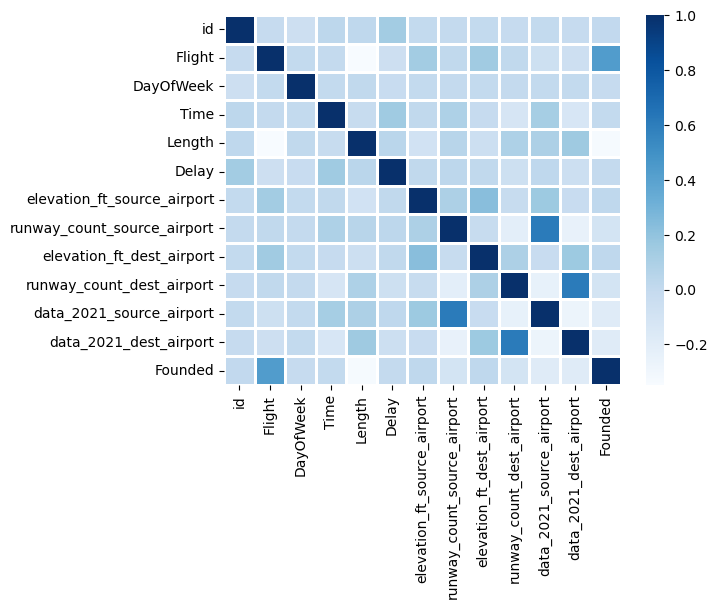

In [173]:
sns.heatmap(corr_matrix, cmap='Blues',linecolor='white', linewidths=2)
plt.show()

# Project Task: Machine Learning

## 1. Use OneHotEncoder and OrdinalEncoder to deal with categorical variables.

In [175]:
master_df.isna().sum()

id                             0
Airline                        0
Flight                         0
AirportFrom                    0
AirportTo                      0
DayOfWeek                      0
Time                           0
Length                         0
Delay                          0
type_source_airport            0
elevation_ft_source_airport    0
runway_count_source_airport    0
type_dest_airport              0
elevation_ft_dest_airport      0
runway_count_dest_airport      0
data_2021_source_airport       0
data_2021_dest_airport         0
Founded                        0
Airlines ID                    0
Description                    0
duration                       0
dtype: int64

In [174]:
master_df.to_csv('Master_Dataset.csv')
master_df.to_excel('Master_Dataset.xlsx')

In [177]:
master_df.drop(columns = ['id', 'Flight',  'duration','Airline', 'AirportFrom', 'AirportTo'], inplace = True)
master_df.head(3)

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded,Airlines ID,Description
0,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0,CO,United Airlines (initially CO)
1,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0,CO,United Airlines (initially CO)
2,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0,CO,United Airlines (initially CO)


In [178]:
master_df.drop(columns = ['Airlines ID', 'Description'], inplace = True)
master_df.head(3)

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,11725347.0,16242821.0,1934.0
1,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,23663410.0,16242821.0,1934.0
2,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,2184959.0,17430195.0,1934.0


In [232]:
master_df.type_dest_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [233]:
master_df.type_source_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [237]:
ordinal = OrdinalEncoder(categories=[['medium_airport', 'large_airport'],['medium_airport', 'large_airport']])
ordinal.fit(master_df[['type_source_airport', 'type_dest_airport']])

OrdinalEncoder(categories=[['medium_airport', 'large_airport'],
                           ['medium_airport', 'large_airport']])

In [238]:
master_df[['type_source_airport', 'type_dest_airport']] = ordinal.transform(master_df[['type_source_airport', 'type_dest_airport']])

In [239]:
master_df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,Founded
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,11725347.0,16242821.0,1934.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,23663410.0,16242821.0,1934.0
2,3,49,201,1,1.0,152.0,3.0,1.0,433.0,4.0,2184959.0,17430195.0,1934.0
3,3,60,162,0,1.0,2181.0,4.0,1.0,97.0,5.0,19160342.0,16242821.0,1934.0
4,3,75,167,0,1.0,944.0,2.0,1.0,97.0,5.0,2201528.0,16242821.0,1934.0


In [240]:
master_df['years_of_operation'] = 2023 - master_df['Founded']

In [242]:
master_df.drop(['Founded'],axis=1,inplace=True)

In [243]:
master_df.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,years_of_operation
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,11725347.0,16242821.0,89.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,23663410.0,16242821.0,89.0
2,3,49,201,1,1.0,152.0,3.0,1.0,433.0,4.0,2184959.0,17430195.0,89.0
3,3,60,162,0,1.0,2181.0,4.0,1.0,97.0,5.0,19160342.0,16242821.0,89.0
4,3,75,167,0,1.0,944.0,2.0,1.0,97.0,5.0,2201528.0,16242821.0,89.0


In [244]:
master_df.shape

(516217, 13)

## 2.	Perform the following model building steps:
### (a)	Apply logistic regression (use stochastic gradient descent optimizer) and decision tree models
### (b)	Use the stratified five-fold method to build and validate the models
Note: Make sure you use standardization effectively, ensuring no data leakage and leverage pipelines to have a cleaner code
### (c)	Use RandomizedSearchCV for hyperparameter tuning, and use k-fold for cross- validation
### (d)	Keep a few data points (10%) for prediction purposes to evaluate how you would make the final prediction, and do not use this data for testing or validation
Note: The final prediction will be based on the voting (majority class by 5 models created using the stratified 5-fold method)
### (g) Compare the results of logistic regression and decision tree classifier


In [245]:
model = master_df.copy()
model.head()

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,data_2021_source_airport,data_2021_dest_airport,years_of_operation
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,11725347.0,16242821.0,89.0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,23663410.0,16242821.0,89.0
2,3,49,201,1,1.0,152.0,3.0,1.0,433.0,4.0,2184959.0,17430195.0,89.0
3,3,60,162,0,1.0,2181.0,4.0,1.0,97.0,5.0,19160342.0,16242821.0,89.0
4,3,75,167,0,1.0,944.0,2.0,1.0,97.0,5.0,2201528.0,16242821.0,89.0


In [250]:
X = model.drop(['Delay'],axis=1)
y = model.Delay

In [251]:
print(X.shape)
print(y.shape)

(516217, 12)
(516217,)


In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(412973, 12)
(103244, 12)
(412973,)
(103244,)


In [253]:
# We will use X_train in K-fold Cross validation and X_test during final prediction.

In [254]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)
accuracy_train = {}
accuracy_test = {}
final_predictions_sgd = {}
i = 1
for train_index, test_index in folds.split(X_train,y_train):
    print('iter ', i)
    train,test = model.loc[train_index,], model.loc[test_index,]
    sc = StandardScaler()
    sgd = SGDClassifier()
    
    # define search space
    
    space = dict()
    space['sgd__penalty'] = ['l1', 'l2', 'elasticnet']
    space['sgd__l1_ratio'] = [0,.1,.2,.8,1]
    space['sgd__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000,10000] 
    space['sgd__learning_rate'] = ['constant', 'adaptive'] 
    space['sgd__eta0']=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1 , 2e-1, 3e-1, 5e-1, 8e-1, 4e-1, 8e-1, 1, 10, 100] 
    
    pipe = Pipeline([('sc',sc), ('sgd', sgd)])
    
    # define search
    search = RandomizedSearchCV( pipe, space, scoring='accuracy', 
                                cv=5, refit=True, return_train_score = True,
                                random_state = 12, n_jobs = -1, n_iter = 2
                           )
    
    # execute search
    fold_X_train = train.drop(columns = 'Delay')
    fold_y_train = train.Delay
    
    result = search.fit(fold_X_train, fold_y_train)

    train_pred = result.predict(fold_X_train)
    
    fold_X_test = test.drop(columns = 'Delay')
    fold_y_test = test.Delay
    test_pred = result.predict(fold_X_test)
    final_predictions_sgd.update({'Fold{}'.format(i):result.predict(X_test)})
    
    # get rmse for each fold for train data 
    accuracy_train.update({'Fold{}'.format(i): round(accuracy_score(y_true = fold_y_train, y_pred = train_pred)*100,3)})
    accuracy_test.update({'Fold{}'.format(i): round(accuracy_score(y_true = fold_y_test, y_pred = test_pred) * 100,3)})
    i += 1

iter  1
iter  2
iter  3
iter  4
iter  5


In [256]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)
dt_accuracy_train = {}
dt_accuracy_test = {}
final_predictions_dt = {}
i = 1
for train_index, test_index in folds.split(X_train,y_train):
    print('iter ', i)
    
    train, test = model.loc[train_index,], model.loc[test_index,]
    
    sc = StandardScaler()
    dt = DecisionTreeClassifier()
    
    
    # define search space
    space = dict()
    space['dt__min_samples_split'] = [25000, 30000, 35000, 40000, 45000, 50000, 60000 ]
    space['dt__min_samples_leaf'] = [10000, 15000, 20000]
    
    pipe = Pipeline([('sc',sc), ('dt', dt)])
    
    # define search
    search = RandomizedSearchCV( pipe, space, scoring='accuracy', 
                                cv=5, refit=True, return_train_score = True,
                                random_state = 12, n_jobs = -1, n_iter = 2
                           )
    
    # execute search
    fold_X_train = train.drop(columns = 'Delay')
    fold_y_train = train.Delay
    
    result = search.fit(fold_X_train, fold_y_train)

    train_pred = result.predict(fold_X_train)
    
    fold_X_test = test.drop(columns = 'Delay')
    fold_y_test = test.Delay
    test_pred = result.predict(fold_X_test)
    final_predictions_dt.update({'Fold{}'.format(i):result.predict(X_test)})
    
    # get rmse for each fold for train data 
    dt_accuracy_train.update({'Fold{}'.format(i): round(accuracy_score(y_true = fold_y_train, y_pred = train_pred)*100,3)})
    dt_accuracy_test.update({'Fold{}'.format(i): round(accuracy_score(y_true = fold_y_test, y_pred = test_pred) * 100,3)})
    i += 1

iter  1
iter  2
iter  3
iter  4
iter  5


In [257]:
# compare results : 
train_results = pd.DataFrame ({'sgd' : accuracy_train.values(), 'dt': dt_accuracy_train.values() },
                             index = ['Fold {}'.format(i) for i in range(1,6)])
train_results

,sgd,dt
Fold 1,60.380,61.110
Fold 2,60.433,61.275
Fold 3,60.432,61.160
Fold 4,60.455,61.276
Fold 5,60.477,61.256


In [258]:
test_results = pd.DataFrame ({'sgd' : accuracy_test.values(), 'dt': dt_accuracy_test.values() },
                             index = ['Fold {}'.format(i) for i in range(1,6)])
test_results

,sgd,dt
Fold 1,60.659,61.298
Fold 2,60.444,61.165
Fold 3,60.450,61.015
Fold 4,60.355,61.234
Fold 5,60.268,61.242


In [259]:
final_predictions_dt

{'Fold1': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold2': array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold3': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold4': array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold5': array([1, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [260]:
final_predictions_sgd

{'Fold1': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold2': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold3': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold4': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Fold5': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

## 3.	Use the stratified five-fold method to build and validate the models using the XGB classifier, compare all methods, and share your findings

In [261]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)
xgb_accuracy_train = {}
xgb_accuracy_test = {}
final_predictions_xgb = []

i = 1
for train_index, test_index in folds.split(X_train,y_train):
    print('iter ', i)
    train, test = model.loc[train_index,], model.loc[test_index,]
    sc = StandardScaler()
    xgb_r = XGBClassifier(random_state = 12, use_label_encoder = False)

    # define search space
    space = dict()
    space['xgb_r__n_estimators'] = [40,50,60]
    space['xgb_r__max_depth'] = [3,4,5]
    space['xgb_r__colsample_bytree']:[0.4,.5,.6]
    space['xgb_r__lambda'] = [.0001,.002,.0004,.0003]
    space['xgb_r__alpha'] = [.01,.02,.1,.4]
    
    pipe = Pipeline([('sc',sc), ('xgb_r', xgb_r)])
    
    # define search
    search = RandomizedSearchCV( pipe, space, scoring='neg_root_mean_squared_error', 
                                cv=5, refit=True, return_train_score = True,
                                random_state = 12, n_jobs = -1, n_iter = 2
                           )
    
    # execute search
    fold_X_train = train.drop(columns = 'Delay')
    fold_y_train = train.Delay
    
    result = search.fit(fold_X_train, fold_y_train)

    train_pred = result.predict(fold_X_train)
    
    fold_X_test = test.drop(columns = 'Delay')
    fold_y_test = test.Delay
    test_pred = result.predict(fold_X_test)
    
    final_predictions_xgb.append(result.predict(X_test))  
    
    # get rmse for each fold for train data 
    xgb_accuracy_train.update({'Fold{}'.format(i): round(accuracy_score(y_true = fold_y_train, y_pred = train_pred),3)})
    xgb_accuracy_test.update({'Fold{}'.format(i): round(accuracy_score(y_true = fold_y_test, y_pred = test_pred),3)})
    i += 1

iter  1
[19:49:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iter  2
[19:50:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iter  3
[19:51:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behav

In [266]:
train_results['xgb'] = xgb_accuracy_train.values()
test_results['xgb'] = xgb_accuracy_test.values()

In [267]:
train_results

,sgd,dt,xgb
Fold 1,60.380,61.110,0.642
Fold 2,60.433,61.275,0.640
Fold 3,60.432,61.160,0.643
Fold 4,60.455,61.276,0.643
Fold 5,60.477,61.256,0.638


In [269]:
train_results['xgb']=train_results['xgb']*100

In [270]:
train_results

,sgd,dt,xgb
Fold 1,60.380,61.110,64.2
Fold 2,60.433,61.275,64.0
Fold 3,60.432,61.160,64.3
Fold 4,60.455,61.276,64.3
Fold 5,60.477,61.256,63.8


In [271]:
test_results['xgb']=test_results['xgb']*100

In [272]:
test_results

,sgd,dt,xgb
Fold 1,60.659,61.298,64.0
Fold 2,60.444,61.165,64.0
Fold 3,60.450,61.015,63.8
Fold 4,60.355,61.234,64.1
Fold 5,60.268,61.242,63.5
